## **Project Introduction**

The goal of this project is to predict which NFL team will win a match based on their recent historical performance. This is a classification problem, where we aim to forecast the outcome (win or loss) of a game using historical team data and performance metrics.

Predicting NFL game outcomes benefits:
- **Coaches** by refining strategies,
- **Analysts** by providing insights,
- **Betting companies** by setting better odds, and
- **Fans** by boosting engagement.

By analyzing historical performance data, we can uncover patterns that inform decision-making for team preparation, betting strategies, and fan interactions. This improves outcomes for all stakeholders involved, from optimizing team tactics to generating content for fans.


In [404]:
import pandas as pd

In [405]:
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [406]:
# Read in base data from csv
df = pd.read_csv('nfl.csv')
df.head(5)

,Rk,Team,Date,Season,Pts,PtsO,Rate,TO,Y/P,DY/P,ToP,Rate.1,Att,Att.1,Day,G#,Week,Away,Opp,Result,Pts.1,PtsO.1,PtDif,PC,Cmp,Att.2,Inc,Cmp%,Yds,TD,Int,TD%,Int%,Rate.2,Sk,Yds.1,Sk%,Y/A,NY/A,AY/A,ANY/A,Y/C,Rush_Att,Rush_Yds,Rush_Y/A,TD.1,Tot,Ply,Y/P.1,DPly,DY/P.1,TO.1,ToP.1,Time,Cmp.1,Att.3,Cmp%.1,Yds.2,TD.2,Sk.1,Yds.3,Int.1,Rate.3,Opp_Rush_Att,Opp_Rush_Yds,Y/A.1,TD.3,Rush,Pass,Tot.1,TO.2
0,1,DET,2024-12-05,2024,34,31,109.7,0,5.14,6.62,36:06,110.2,34,24,Thu,13,14,NaN,GNB,W 34-31,34,31,3,65,32,41,9,78.0,280,3,1,7.3,2.4,109.7,1,3,2.38,6.8,6.67,7.20,7.02,8.8,34,111,3.3,1,391,76,5.14,45,6.62,1,36:06,3:12,12,20,60.0,199,1,1,7,0,110.2,24,99,4.1,3,12,81,93,0
1,2,GNB,2024-12-05,2024,31,34,111.7,0,6.62,5.14,23:54,109.3,24,34,Thu,13,14,@,DET,L 31-34,31,34,-3,65,12,20,8,60.0,199,1,0,5.0,0.0,111.7,1,7,4.76,10.0,9.48,10.95,10.43,16.6,24,99,4.1,3,298,45,6.62,76,5.14,1,23:54,3:12,32,41,78.0,280,3,1,3,1,109.3,34,111,3.3,1,-12,-81,-93,0
2,3,DEN,2024-12-02,2024,41,32,65.7,1,6.56,6.57,27:50,86.5,26,23,Mon,13,13,NaN,CLE,W 41-32,41,32,9,73,18,35,17,51.4,294,1,2,2.9,5.7,65.7,0,0,0.00,8.4,8.40,6.40,6.40,16.3,26,106,4.1,2,400,61,6.56,84,6.57,2,27:50,3:29,34,58,58.6,475,4,3,22,3,86.5,23,77,3.3,0,29,-181,-152,1
3,4,CLE,2024-12-02,2024,32,41,88.1,-1,6.57,6.56,32:10,65.7,23,26,Mon,12,13,@,DEN,L 32-41,32,41,-9,73,34,58,24,58.6,475,4,3,6.9,5.2,88.1,3,22,4.92,8.2,7.79,7.24,6.89,14.0,23,77,3.3,0,552,84,6.57,61,6.56,3,32:10,3:29,18,35,51.4,294,1,0,0,2,65.7,26,106,4.1,2,-29,181,152,-1
4,5,JAX,2024-12-01,2024,20,23,83.0,-1,5.57,5.34,27:43,92.5,25,25,Sun,12,13,NaN,HOU,L 20-23,20,23,-3,43,24,42,18,57.1,276,2,1,4.8,2.4,83.0,0,0,0.00,6.6,6.57,6.45,6.45,11.5,25,97,3.9,0,373,67,5.57,61,5.34,1,27:43,3:18,22,34,64.7,218,1,2,24,0,92.5,25,108,4.3,1,-11,58,47,-1


### **Data Cleaning**
Here is the general overview of the steps we took during data cleaning.

- **Handle missing/invalid values**: Fill in or remove missin/invalid data to maintain dataset integrity.
- **Standardize formats & data types & units**: Ensure consistency in date formats, data types, and measurement units.
- **Remove unnecessary columns**: Drop irrelevant columns to simplify the dataset.
- **Anomoly detection & filter outliers**: Identify and manage extreme values that may distort analysis.


#### **Handle Missing/Invalid Values**
To handle missing values, we count the number of null values in each column.
- We can see that the data is quite complete, with no null values except in the away column.
- Upon further inspection of the away column, it can be seen that the NaN value is used to denote that the current team is at home and the @ value is used to denote that the current team is away.
- Therefore, we do not need to handle any missing values.

Upon further data inspection, we found that some games ended in a tie.
- We will be considering this an invalid type since we are only trying to predict a win or loss
- Therefore, all rows which have a tie result will be removed.

In [407]:
# Handle missing values

null_counts = df.isnull().sum()

if (null_counts > 0).any():
    print(null_counts[null_counts > 0])

Away    739
dtype: int64


In [408]:
# Handle invalid values

df = df[~df['Result'].str[0].isin(['T'])]

#### **Standardize Formats, Data Types, & Units**

Before we complete the other steps in data cleaning, we should perform data standardization to make comparisons easier. This includes:
- Check that each column has a consistent type.
  - Our check found that each column had a consitent type except 'Away', which we handle in the next step.
- Standardizing non-numeric / categorical data.
  - Here we print out any columns without the 'int64' or 'float64' type.
  - Then we go through each column and turn those into a standardized type.
  - As a final check, we print the data type of each column and double check by inspecing the data.
- Confirming consistent units.
  - Since the source of the data provides units, they are expected to be consistent.
  - However, this is further checked by a visual inspection of the data and any outliers/anomolies which may be detected.

In [409]:
# Check that each column has a consistent type
for column in df.columns:
  if df[column].map(type).nunique() > 1:
    print(f"Column '{column}' contains mixed types.")

Column 'Away' contains mixed types.


In [410]:
# Standardizing non-numeric data
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64'])
print(non_numeric_columns.dtypes)

Team      object
Date      object
ToP       object
Day       object
Away      object
Opp       object
Result    object
ToP.1     object
Time      object
dtype: object


In [411]:
# Standardizing non-numeric data
df['Date'] = pd.to_datetime(df['Date'])

def convert_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds
df['ToP'] = df['ToP'].apply(convert_to_seconds)
df['ToP.1'] = df['ToP.1'].apply(convert_to_seconds)

df['Away'] = df['Away'].isna().astype(int)

def convert_to_minutes(time_str):
    return int(time_str.split(':')[0])
df['Time'] = df['Time'].apply(convert_to_minutes)

df['Result'] = df['Result'].str[0].map({'W': 1, 'L': 0})

In [412]:
# Standardizing non-numeric data
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64'])
print(non_numeric_columns.dtypes)

Team            object
Date    datetime64[ns]
Day             object
Away             int32
Opp             object
dtype: object


In [413]:
# Standardizing non-numeric data
df.head(5)

,Rk,Team,Date,Season,Pts,PtsO,Rate,TO,Y/P,DY/P,ToP,Rate.1,Att,Att.1,Day,G#,Week,Away,Opp,Result,Pts.1,PtsO.1,PtDif,PC,Cmp,Att.2,Inc,Cmp%,Yds,TD,Int,TD%,Int%,Rate.2,Sk,Yds.1,Sk%,Y/A,NY/A,AY/A,ANY/A,Y/C,Rush_Att,Rush_Yds,Rush_Y/A,TD.1,Tot,Ply,Y/P.1,DPly,DY/P.1,TO.1,ToP.1,Time,Cmp.1,Att.3,Cmp%.1,Yds.2,TD.2,Sk.1,Yds.3,Int.1,Rate.3,Opp_Rush_Att,Opp_Rush_Yds,Y/A.1,TD.3,Rush,Pass,Tot.1,TO.2
0,1,DET,2024-12-05,2024,34,31,109.7,0,5.14,6.62,2166,110.2,34,24,Thu,13,14,1,GNB,1,34,31,3,65,32,41,9,78.0,280,3,1,7.3,2.4,109.7,1,3,2.38,6.8,6.67,7.20,7.02,8.8,34,111,3.3,1,391,76,5.14,45,6.62,1,2166,3,12,20,60.0,199,1,1,7,0,110.2,24,99,4.1,3,12,81,93,0
1,2,GNB,2024-12-05,2024,31,34,111.7,0,6.62,5.14,1434,109.3,24,34,Thu,13,14,0,DET,0,31,34,-3,65,12,20,8,60.0,199,1,0,5.0,0.0,111.7,1,7,4.76,10.0,9.48,10.95,10.43,16.6,24,99,4.1,3,298,45,6.62,76,5.14,1,1434,3,32,41,78.0,280,3,1,3,1,109.3,34,111,3.3,1,-12,-81,-93,0
2,3,DEN,2024-12-02,2024,41,32,65.7,1,6.56,6.57,1670,86.5,26,23,Mon,13,13,1,CLE,1,41,32,9,73,18,35,17,51.4,294,1,2,2.9,5.7,65.7,0,0,0.00,8.4,8.40,6.40,6.40,16.3,26,106,4.1,2,400,61,6.56,84,6.57,2,1670,3,34,58,58.6,475,4,3,22,3,86.5,23,77,3.3,0,29,-181,-152,1
3,4,CLE,2024-12-02,2024,32,41,88.1,-1,6.57,6.56,1930,65.7,23,26,Mon,12,13,0,DEN,0,32,41,-9,73,34,58,24,58.6,475,4,3,6.9,5.2,88.1,3,22,4.92,8.2,7.79,7.24,6.89,14.0,23,77,3.3,0,552,84,6.57,61,6.56,3,1930,3,18,35,51.4,294,1,0,0,2,65.7,26,106,4.1,2,-29,181,152,-1
4,5,JAX,2024-12-01,2024,20,23,83.0,-1,5.57,5.34,1663,92.5,25,25,Sun,12,13,1,HOU,0,20,23,-3,43,24,42,18,57.1,276,2,1,4.8,2.4,83.0,0,0,0.00,6.6,6.57,6.45,6.45,11.5,25,97,3.9,0,373,67,5.57,61,5.34,1,1663,3,22,34,64.7,218,1,2,24,0,92.5,25,108,4.3,1,-11,58,47,-1


#### **Remove Unnecessary Columns**

To simplify our dataset, we should look to see if there are any unncessary columns. This can include:
- Columns containing irrelavent information
  - Upon inspection of the data, we can see that the 'Rk' column served as an index column. 
  - Therefore, the 'Rk' column can be considered to contain irrelavent information to out model and thus removed.
- Columns with constant data
  - No columns were found to have constant data
- Columns with excessive missing data
  - Since we have handled and discovered no missing values, we do not need to account for this case
- Columns with identical data (we will keep the first column alphabetically for each duplicate)
  - Column 'Att' is a duplicate of column 'Rush_Att'
  - Column 'Att.1' is a duplicate of column 'Opp_Rush_Att'
  - Column 'DY/P' is a duplicate of column 'DY/P.1'
  - Column 'Pts' is a duplicate of column 'Pts.1'
  - Column 'PtsO' is a duplicate of column 'PtsO.1'
  - Column 'Rate' is a duplicate of column 'Rate.2'
  - Column 'Rate.1' is a duplicate of column 'Rate.3'
  - Column 'TO' is a duplicate of column 'TO.2'
  - Column 'ToP' is a duplicate of column 'ToP.1'
  - Column 'Y/P' is a duplicate of column 'Y/P.1'

In [414]:
# Columns containing irrelavent information
df.drop('Rk', axis=1, inplace=True)
df.head(5)

,Team,Date,Season,Pts,PtsO,Rate,TO,Y/P,DY/P,ToP,Rate.1,Att,Att.1,Day,G#,Week,Away,Opp,Result,Pts.1,PtsO.1,PtDif,PC,Cmp,Att.2,Inc,Cmp%,Yds,TD,Int,TD%,Int%,Rate.2,Sk,Yds.1,Sk%,Y/A,NY/A,AY/A,ANY/A,Y/C,Rush_Att,Rush_Yds,Rush_Y/A,TD.1,Tot,Ply,Y/P.1,DPly,DY/P.1,TO.1,ToP.1,Time,Cmp.1,Att.3,Cmp%.1,Yds.2,TD.2,Sk.1,Yds.3,Int.1,Rate.3,Opp_Rush_Att,Opp_Rush_Yds,Y/A.1,TD.3,Rush,Pass,Tot.1,TO.2
0,DET,2024-12-05,2024,34,31,109.7,0,5.14,6.62,2166,110.2,34,24,Thu,13,14,1,GNB,1,34,31,3,65,32,41,9,78.0,280,3,1,7.3,2.4,109.7,1,3,2.38,6.8,6.67,7.20,7.02,8.8,34,111,3.3,1,391,76,5.14,45,6.62,1,2166,3,12,20,60.0,199,1,1,7,0,110.2,24,99,4.1,3,12,81,93,0
1,GNB,2024-12-05,2024,31,34,111.7,0,6.62,5.14,1434,109.3,24,34,Thu,13,14,0,DET,0,31,34,-3,65,12,20,8,60.0,199,1,0,5.0,0.0,111.7,1,7,4.76,10.0,9.48,10.95,10.43,16.6,24,99,4.1,3,298,45,6.62,76,5.14,1,1434,3,32,41,78.0,280,3,1,3,1,109.3,34,111,3.3,1,-12,-81,-93,0
2,DEN,2024-12-02,2024,41,32,65.7,1,6.56,6.57,1670,86.5,26,23,Mon,13,13,1,CLE,1,41,32,9,73,18,35,17,51.4,294,1,2,2.9,5.7,65.7,0,0,0.00,8.4,8.40,6.40,6.40,16.3,26,106,4.1,2,400,61,6.56,84,6.57,2,1670,3,34,58,58.6,475,4,3,22,3,86.5,23,77,3.3,0,29,-181,-152,1
3,CLE,2024-12-02,2024,32,41,88.1,-1,6.57,6.56,1930,65.7,23,26,Mon,12,13,0,DEN,0,32,41,-9,73,34,58,24,58.6,475,4,3,6.9,5.2,88.1,3,22,4.92,8.2,7.79,7.24,6.89,14.0,23,77,3.3,0,552,84,6.57,61,6.56,3,1930,3,18,35,51.4,294,1,0,0,2,65.7,26,106,4.1,2,-29,181,152,-1
4,JAX,2024-12-01,2024,20,23,83.0,-1,5.57,5.34,1663,92.5,25,25,Sun,12,13,1,HOU,0,20,23,-3,43,24,42,18,57.1,276,2,1,4.8,2.4,83.0,0,0,0.00,6.6,6.57,6.45,6.45,11.5,25,97,3.9,0,373,67,5.57,61,5.34,1,1663,3,22,34,64.7,218,1,2,24,0,92.5,25,108,4.3,1,-11,58,47,-1


In [415]:
# Columns with constant data
constant_columns = df.columns[df.nunique() == 1]
print('Columns with constant data:', constant_columns)

Columns with constant data: Index([], dtype='object')


In [416]:
# Columns with identical data
duplicate_columns = {}
seen_pairs = set()

for col1 in df.columns:
  for col2 in df.columns:
    if col1 != col2 and df[col1].equals(df[col2]):
      if (col1, col2) not in seen_pairs and (col2, col1) not in seen_pairs:
        duplicate_columns[col1] = col2
        seen_pairs.add((col1, col2))

sorted_duplicate_columns = sorted(duplicate_columns.items())

for col, duplicate in sorted_duplicate_columns:
  print(f"Column '{col}' is a duplicate of column '{duplicate}'")

duplicated_columns_list = list(set(duplicate_columns.keys()).union(duplicate_columns.values()))
print(df[duplicated_columns_list].head(5).T.sort_index(axis=0))


Column 'Att' is a duplicate of column 'Rush_Att'
Column 'Att.1' is a duplicate of column 'Opp_Rush_Att'
Column 'DY/P' is a duplicate of column 'DY/P.1'
Column 'Pts' is a duplicate of column 'Pts.1'
Column 'PtsO' is a duplicate of column 'PtsO.1'
Column 'Rate' is a duplicate of column 'Rate.2'
Column 'Rate.1' is a duplicate of column 'Rate.3'
Column 'TO' is a duplicate of column 'TO.2'
Column 'ToP' is a duplicate of column 'ToP.1'
Column 'Y/P' is a duplicate of column 'Y/P.1'
                    0        1        2        3        4
Att             34.00    24.00    26.00    23.00    25.00
Att.1           24.00    34.00    23.00    26.00    25.00
DY/P             6.62     5.14     6.57     6.56     5.34
DY/P.1           6.62     5.14     6.57     6.56     5.34
Opp_Rush_Att    24.00    34.00    23.00    26.00    25.00
Pts             34.00    31.00    41.00    32.00    20.00
Pts.1           34.00    31.00    41.00    32.00    20.00
PtsO            31.00    34.00    32.00    41.00    23.0

In [417]:
# Columns with identical data
for col1, duplicate in duplicate_columns.items():
 if duplicate in df.columns:
    df.drop(duplicate, axis=1, inplace=True)

df.head(5)

,Team,Date,Season,Pts,PtsO,Rate,TO,Y/P,DY/P,ToP,Rate.1,Att,Att.1,Day,G#,Week,Away,Opp,Result,PtDif,PC,Cmp,Att.2,Inc,Cmp%,Yds,TD,Int,TD%,Int%,Sk,Yds.1,Sk%,Y/A,NY/A,AY/A,ANY/A,Y/C,Rush_Yds,Rush_Y/A,TD.1,Tot,Ply,DPly,TO.1,Time,Cmp.1,Att.3,Cmp%.1,Yds.2,TD.2,Sk.1,Yds.3,Int.1,Opp_Rush_Yds,Y/A.1,TD.3,Rush,Pass,Tot.1
0,DET,2024-12-05,2024,34,31,109.7,0,5.14,6.62,2166,110.2,34,24,Thu,13,14,1,GNB,1,3,65,32,41,9,78.0,280,3,1,7.3,2.4,1,3,2.38,6.8,6.67,7.20,7.02,8.8,111,3.3,1,391,76,45,1,3,12,20,60.0,199,1,1,7,0,99,4.1,3,12,81,93
1,GNB,2024-12-05,2024,31,34,111.7,0,6.62,5.14,1434,109.3,24,34,Thu,13,14,0,DET,0,-3,65,12,20,8,60.0,199,1,0,5.0,0.0,1,7,4.76,10.0,9.48,10.95,10.43,16.6,99,4.1,3,298,45,76,1,3,32,41,78.0,280,3,1,3,1,111,3.3,1,-12,-81,-93
2,DEN,2024-12-02,2024,41,32,65.7,1,6.56,6.57,1670,86.5,26,23,Mon,13,13,1,CLE,1,9,73,18,35,17,51.4,294,1,2,2.9,5.7,0,0,0.00,8.4,8.40,6.40,6.40,16.3,106,4.1,2,400,61,84,2,3,34,58,58.6,475,4,3,22,3,77,3.3,0,29,-181,-152
3,CLE,2024-12-02,2024,32,41,88.1,-1,6.57,6.56,1930,65.7,23,26,Mon,12,13,0,DEN,0,-9,73,34,58,24,58.6,475,4,3,6.9,5.2,3,22,4.92,8.2,7.79,7.24,6.89,14.0,77,3.3,0,552,84,61,3,3,18,35,51.4,294,1,0,0,2,106,4.1,2,-29,181,152
4,JAX,2024-12-01,2024,20,23,83.0,-1,5.57,5.34,1663,92.5,25,25,Sun,12,13,1,HOU,0,-3,43,24,42,18,57.1,276,2,1,4.8,2.4,0,0,0.00,6.6,6.57,6.45,6.45,11.5,97,3.9,0,373,67,61,1,3,22,34,64.7,218,1,2,24,0,108,4.3,1,-11,58,47


#### **Anomoly Detection & Filter Outliers**

Anomaly detection is essential to identify and address outliers or errors in the dataset.
This helps to ensure that the analysis remains accurate and the model is not influenced by misleading or irrelevant data points. Note that this is also somewhat part of data exploration.
We followed the steps below:

- Plot distributions for numeric data
	- Before we search for anomolies, is good to visualize how the data is distributed
	- Additionally, we should note that some of the numeric values are inheriently categorical or continous such as:
		- Result
		- Season
		- Time
		- Week
		- G#
- Using the plots, we can inspect to see the types of distributions
	- Only only classified Yds.1 and Yds.3 as "exponential"
	- Everything else is considered to have a "normal" distribution, even if severly skewed







In [418]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [419]:
exclude_columns = ['Result', 'Season', 'Time', 'Week', 'G#']

def get_numeric_columns(df, exclude_columns):
    return sorted([col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in exclude_columns])

numeric_columns = get_numeric_columns(df, exclude_columns)

In [420]:
def fit_distributions(data):
	norm_params = stats.norm.fit(data) # Normal distribution
	
	exp_params = stats.expon.fit(data) # Exponential distribution
	
	if (data > 0).all():
		lognorm_params = stats.lognorm.fit(data) # Log-Normal distribution (if all > 0)
		return norm_params, exp_params, lognorm_params, True
	else:
		return norm_params, exp_params, None, False

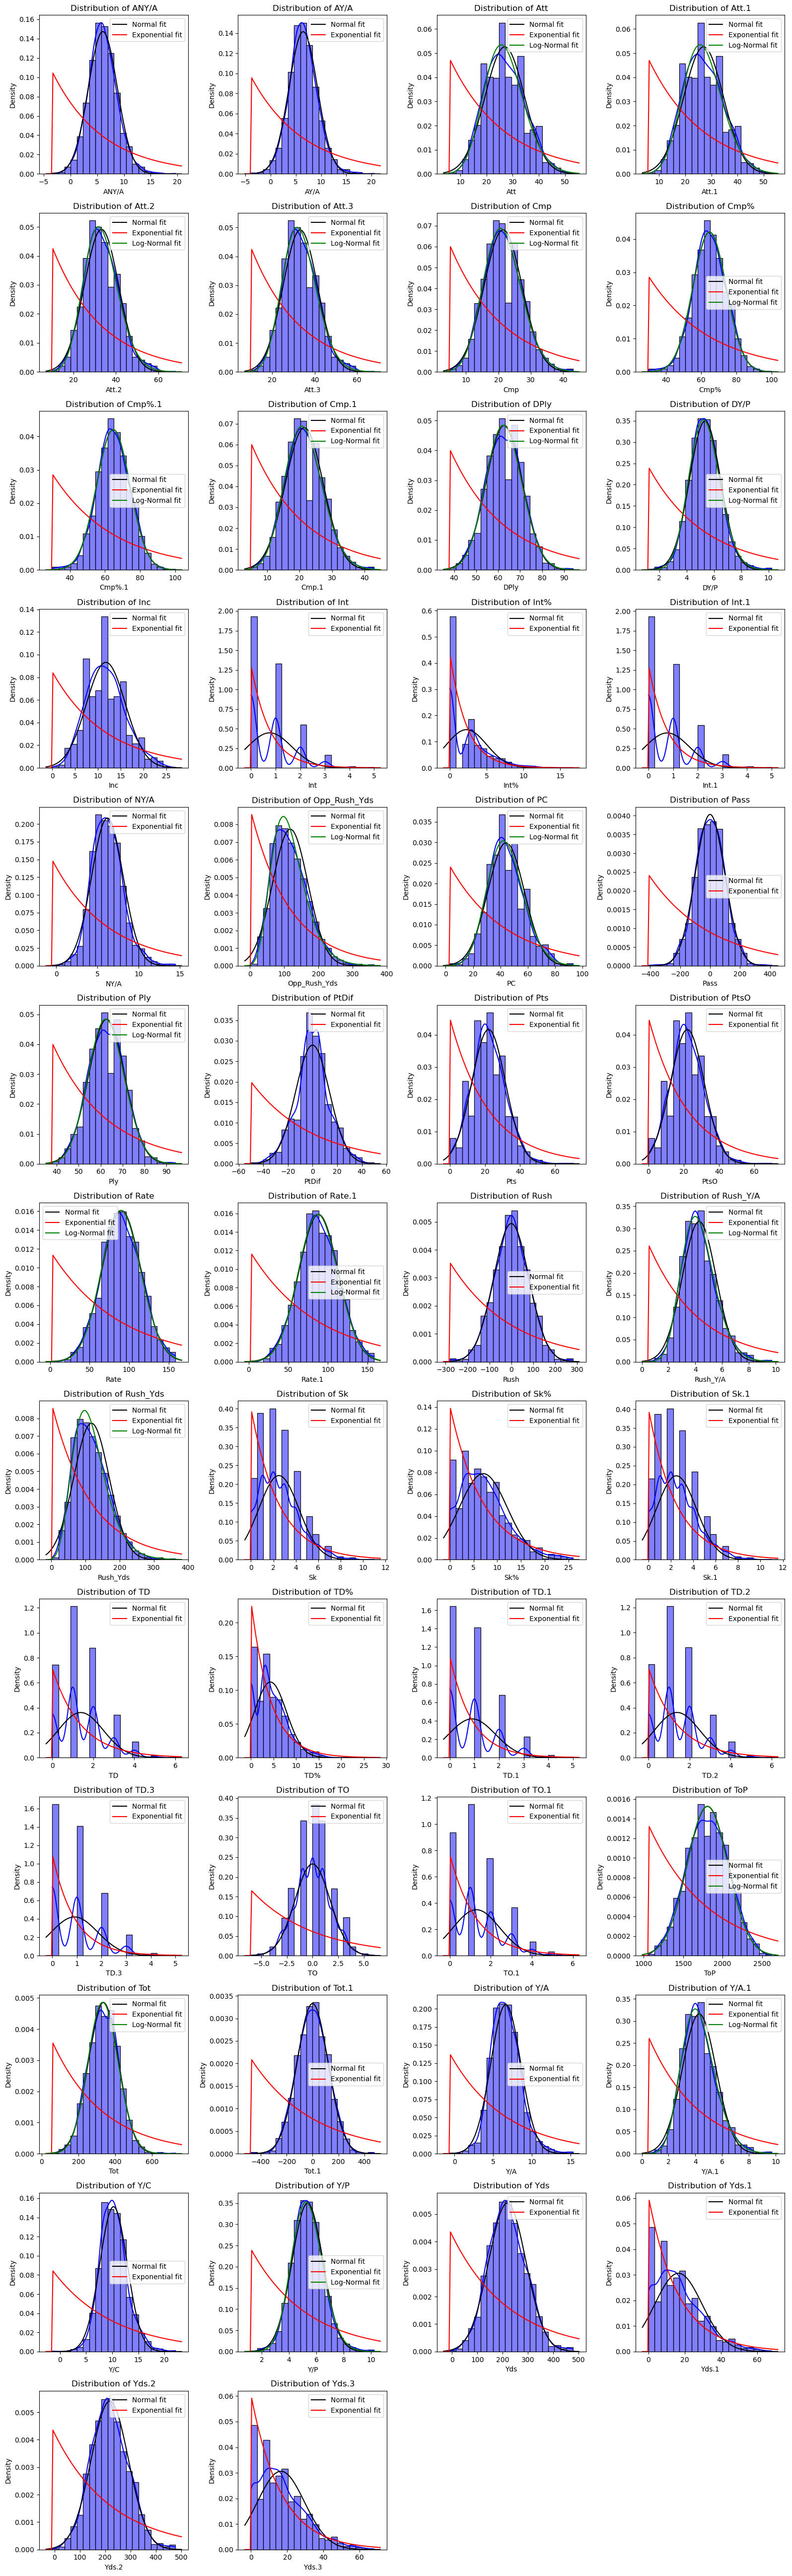

In [421]:


num_cols = 4
num_rows = int(np.ceil(len(numeric_columns) / num_cols))
plt.figure(figsize=(num_cols * 4, num_rows * 4))

for i, col in enumerate(numeric_columns, 1):
	data = df[col]
	norm_params, exp_params, lognorm_params, plot_lognorm = fit_distributions(data)
	plt.subplot(num_rows, num_cols, i)
	sns.histplot(data, kde=True, bins=20, color='blue', stat="density")
	xmin, xmax = plt.xlim()
	x = np.linspace(xmin, xmax, 100)

	p_norm = stats.norm.pdf(x, *norm_params) # Normal distribution
	plt.plot(x, p_norm, 'k-', label=f'Normal fit')

	p_exp = stats.expon.pdf(x, *exp_params) # Exponential distribution
	plt.plot(x, p_exp, 'r-', label=f'Exponential fit')

	if plot_lognorm:
		p_lognorm = stats.lognorm.pdf(x, *lognorm_params) # Log-Normal distribution (if all > 0)
		plt.plot(x, p_lognorm, 'g-', label=f'Log-Normal fit') 

	plt.title(f'Distribution of {col}')
	plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler


In [ ]:
# Assuming df is your cleaned dataframe
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Features that are exponential
exponential_features = ['Yds.1', 'Yds.3']

# Features that are normal (everything except exponential features)
normal_features = [col for col in numeric_columns if col not in exponential_features and col not in ['Result', 'Season', 'Time', 'Week', 'G#']]

# Separate the data
normal_data = df[normal_features]
exponential_data = df[exponential_features]


In [ ]:
# Log-transform the exponential features to make them more normal
exponential_data_log = np.log1p(exponential_data)  # log(1 + x) to handle zero values

# Standardize the normal features using Z-scores
normal_data_standardized = normal_data.apply(zscore)

# If you want, you can standardize exponential features too after the log transformation
exponential_data_log_standardized = exponential_data_log.apply(zscore)


In [ ]:
# Anomaly detection for normal features
normal_anomalies = (np.abs(normal_data_standardized) > 3).any(axis=1)

# Anomaly detection for exponential features (log-transformed)
# exponential_anomalies = (np.abs(exponential_data_log_standardized) > 3).any(axis=1)

# Combine the anomalies from both sets of features
final_anomalies = normal_anomalies | exponential_anomalies


In [400]:
# Add the anomaly flags to the original dataframe (or as a separate column)
df['Anomaly'] = final_anomalies.astype(int)

# Optionally, you can explore or filter the anomalous rows:
anomalous_rows = df[df['Anomaly'] == 1]


In [401]:
# Evaluate the proportion of anomalies detected
print(f"Anomalies detected: {final_anomalies.mean() * 100:.2f}%")


Anomalies detected: 16.69%


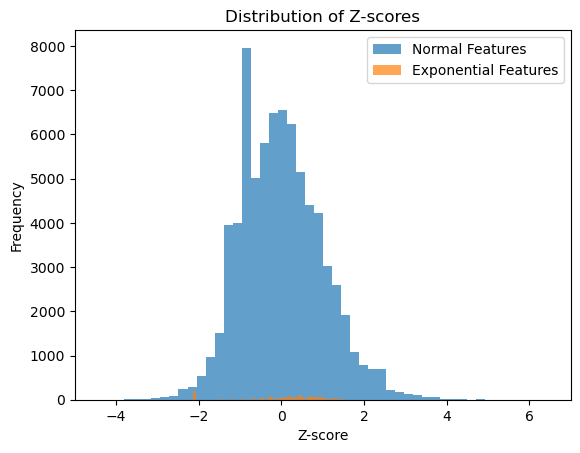

In [402]:
import matplotlib.pyplot as plt

# Plot the Z-scores for normal and log-transformed features
plt.hist(normal_data_standardized.values.flatten(), bins=50, alpha=0.7, label="Normal Features")
plt.hist(exponential_data_log_standardized.values.flatten(), bins=50, alpha=0.7, label="Exponential Features")
plt.title("Distribution of Z-scores")
plt.xlabel("Z-score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Anomalies detected: 61.06%


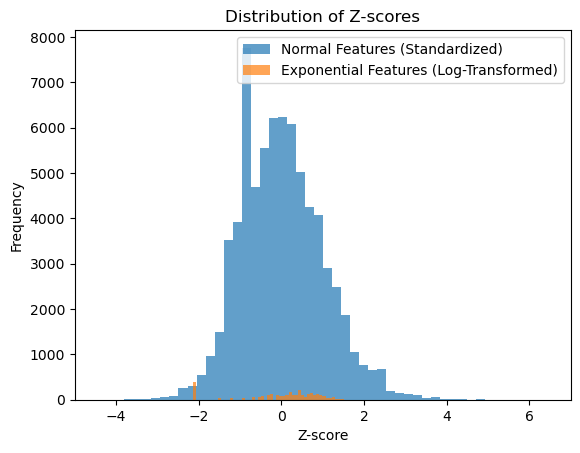

In [422]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, skew
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming df is your cleaned dataframe
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Features that are exponential
exponential_features = ['Yds.1', 'Yds.3']

# Features that are normal (everything except exponential features and excluded columns)
normal_features = [col for col in numeric_columns if col not in exponential_features and col not in ['Result', 'Season', 'Time', 'Week', 'G#']]

# Separate the data
normal_data = df[normal_features]
exponential_data = df[exponential_features]

# Log-transform the exponential features to make them more normal
exponential_data_log = np.log1p(exponential_data)  # log(1 + x) to handle zero values

# Compute the skewness of the normal features
skewness = normal_data.apply(skew)

# Standardize the normal features using Z-scores
normal_data_standardized = normal_data.apply(zscore)

# Adjust the Z-scores based on skewness
# Skew-adjusted Z-scores: we modify the standard Z-scores by multiplying with (1 + skewness)
adjusted_z_scores = normal_data_standardized * (1 + skewness.values)

# Anomaly detection for normal features (skew-adjusted Z-scores)
normal_anomalies = (np.abs(adjusted_z_scores) > 3).any(axis=1)

# Anomaly detection for exponential features (log-transformed)
exponential_data_log_standardized = exponential_data_log.apply(zscore)
exponential_anomalies = (np.abs(exponential_data_log_standardized) > 3).any(axis=1)

# Combine the anomalies from both sets of features
final_anomalies = normal_anomalies | exponential_anomalies

# Add the anomaly flags to the original dataframe (or as a separate column)
df['Anomaly'] = final_anomalies.astype(int)

# Optionally, you can explore or filter the anomalous rows:
anomalous_rows = df[df['Anomaly'] == 1]

# Evaluate the proportion of anomalies detected
print(f"Anomalies detected: {final_anomalies.mean() * 100:.2f}%")

# Plot the Z-scores for normal and log-transformed features
plt.hist(normal_data_standardized.values.flatten(), bins=50, alpha=0.7, label="Normal Features (Standardized)")
plt.hist(exponential_data_log_standardized.values.flatten(), bins=50, alpha=0.7, label="Exponential Features (Log-Transformed)")
plt.title("Distribution of Z-scores")
plt.xlabel("Z-score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


#### Remove Duplicates
Inspecting the dataset shows that there are repeated entries for each game.
More specifically, each game has two entries with:
- 'Team': A and 'Opp': B
- 'Team': B and 'Opp': A

This can be seen in the previous head() in rows 0 and 1.
Upon further general inspection of the csv file, this is determined to be a 
general case.

To remove duplicates, we can use the knowledge that each team does not play more
than one match in any given day. Therefore, for each day, we can see which 
matches are duplicates by comparing the set of the team names. If the sets are
equivalent, the two matches are considered to be duplicates.

Once approach would be to simply remove any one of the two matches. However,
this could potentially lead to a class imbalance of Win/Loss since the matches
are not ordered 
